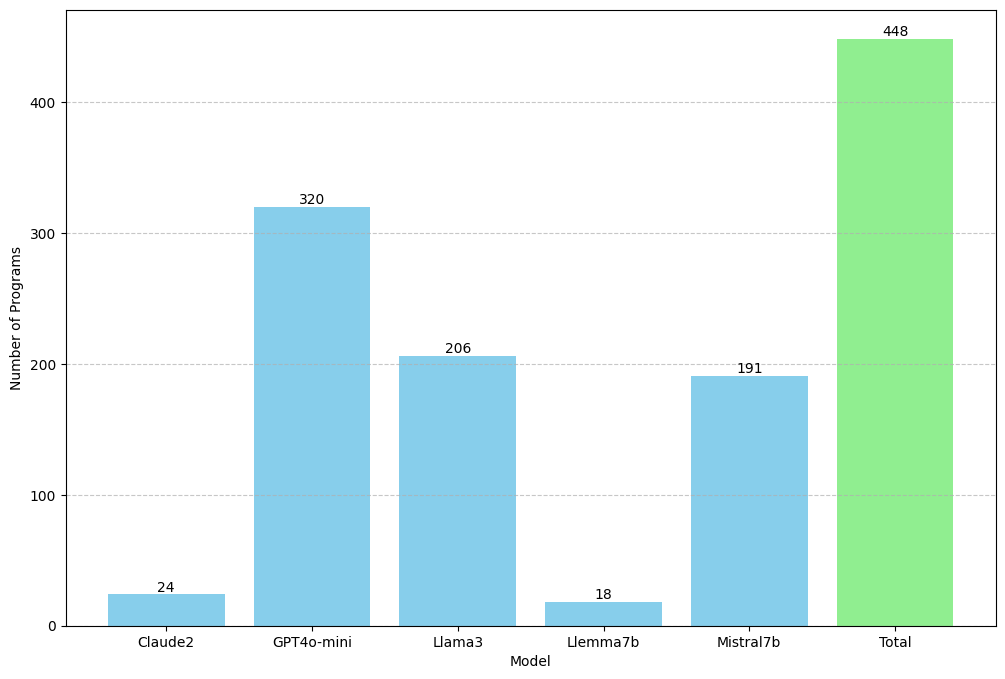

In [2]:
import os
import matplotlib.pyplot as plt

# Define the directories
directories = [
    r"Repair\Claude2\Result",
    r"Repair\GPT4o-mini\Result",
    r"Repair\Llama3\Result",
    r"Repair\Llemma7b\Result",
    r"Repair\Mistral7b\Result",
    r"All_Bugs_Code\Code"
]

# Initialize lists to hold directory names and file counts
labels = []
file_counts = []

# Process each directory
for dir_path in directories:
    # Count the number of files in the directory
    file_count = len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
    
    # Extract the penultimate directory name or use a custom label for the total directory
    if "All_Bugs_Code" in dir_path:
        label = "Total"
    else:
        label = os.path.basename(os.path.dirname(dir_path))
    
    # Append to lists
    labels.append(label)
    file_counts.append(file_count)

# Create the bar chart
plt.figure(figsize=(12, 8))
bars = plt.bar(labels, file_counts, color=['skyblue']*5 + ['lightgreen'])

# Add counts above the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

# Set labels and title
plt.xlabel('Model')
plt.ylabel('Number of Programs')
#plt.title('Number of Files in Each Directory')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


In [5]:
import pandas as pd

# Define the path to the CSV file
file_path = r"Tables\fault_loc_table.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

In [13]:
import os
import pandas as pd

def update_table_with_repair_info(table, directory):
    # Add new columns to the DataFrame
    table['Repaired'] = False
    table['Attempt'] = pd.NA
    table['Repair_Line'] = pd.NA
    table['Repair_Fix'] = pd.NA
    
    # Iterate through each file in the specified directory
    for filename in os.listdir(directory):
        # Get the file name without the extension
        name_without_ext = os.path.splitext(filename)[0]
        
        # Check if the file name is in the 'Name' column of the DataFrame
        if name_without_ext in table['Name'].values:
            # Read the file's content
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r') as file:
                lines = file.readlines()
                if len(lines) >= 2:
                    # Extract values from the file content
                    attempt = int(lines[0].strip())
                    repair_line = int(lines[1].strip())
                    repair_fix = ''.join(lines[2:]).strip()
                    
                    # Update the DataFrame
                    table.loc[table['Name'] == name_without_ext, 'Repaired'] = True
                    table.loc[table['Name'] == name_without_ext, 'Attempt'] = attempt
                    table.loc[table['Name'] == name_without_ext, 'Repair_Line'] = repair_line
                    table.loc[table['Name'] == name_without_ext, 'Repair_Fix'] = repair_fix

    return table


In [20]:
import os
import pandas as pd

def atualizar_tabela_com_reparo_original(tabela):
    base_path = r"dataset\DafnyBench\hints_removed"
    bugs_code_dir = os.path.join(base_path, "Bugs_Code", "Hints")
    correct_code_dir = os.path.join(base_path, "Correct_Code")
    
    # Adiciona a coluna 'Repair_Original' à tabela
    tabela['Repair_Original'] = pd.NA
    
    # Itera sobre cada linha da tabela
    for idx, row in tabela.iterrows():
        tipo = row['Type']
        nome = row['Name']
        
        # Verifica se tipo e nome são válidos (não nulos e são strings)
        if pd.notna(tipo) and pd.notna(nome):
            tipo = str(tipo)
            nome = str(nome)
            
            # Caminho para o arquivo de código com bugs
            bug_file_path = os.path.join(bugs_code_dir, tipo, nome + ".dfy")
            
            # Verifica se o arquivo de código com bugs existe
            if os.path.exists(bug_file_path):
                # Lê o arquivo e localiza a linha com "//buggy line"
                with open(bug_file_path, 'r', encoding='utf-8') as bug_file:
                    lines = bug_file.readlines()
                    for i, line in enumerate(lines):
                        if "//buggy line" in line:
                            buggy_line_index = i + 1  # Índice da linha buggy (contagem começa em 1)
                            break
                    else:
                        buggy_line_index = None
                
                if buggy_line_index is not None:
                    # Extrair o prefixo do nome (antes do último '_')
                    prefixo_nome = nome.rsplit('_', 1)[0] + ".dfy"
                    
                    # Caminho para o arquivo de código correto
                    correct_file_path = os.path.join(correct_code_dir, prefixo_nome)
                    
                    # Verifica se o arquivo de código correto existe
                    if os.path.exists(correct_file_path):
                        # Lê a linha correta no arquivo de código correto
                        with open(correct_file_path, 'r', encoding='utf-8') as correct_file:
                            correct_lines = correct_file.readlines()
                            if buggy_line_index <= len(correct_lines):
                                tabela.at[idx, 'Repair_Original'] = correct_lines[buggy_line_index - 1].strip()
    
    return tabela


In [26]:
import pandas as pd

def remove_spaces_and_newlines(s):
    """Remove all spaces and newline characters from a string if it's not NA."""
    if pd.notna(s) and isinstance(s, str):
        return s.replace(" ", "").replace("\n", "")
    return s

def compare_repair_columns(row):
    """Check if 'Repair_Original' is a substring of 'Repair_Fix', ignoring spaces and newlines."""
    original = remove_spaces_and_newlines(row['Repair_Original'])
    fix = remove_spaces_and_newlines(row['Repair_Fix'])
    # Ensure we handle NA values gracefully
    if pd.notna(original) and pd.notna(fix):
        return original in fix
    return False

def atualizar_tabela_com_reparo_comparacao(tabela):
    # Adiciona a coluna 'Repair_Same' à tabela
    tabela['Repair_Same'] = tabela.apply(compare_repair_columns, axis=1)
    return tabela

## Mistral7b

In [8]:
mistral_table = df.copy()
mistral_table.columns

Index(['Name', 'Fault_Loc', 'Total_Lines', 'Type', 'Line', 'Verify',
       'Fault_Loc_Percentage', 'Category', 'Total_Lines_Num'],
      dtype='object')

In [14]:
mistral_table = update_table_with_repair_info(mistral_table, r"Repair\Mistral7b\Result")

In [21]:
mistral_table = atualizar_tabela_com_reparo_original(mistral_table)

In [27]:
mistral_table_df = atualizar_tabela_com_reparo_comparacao(mistral_table)

In [33]:
# Optionally, save the table to a CSV file
output_csv = r'Tables\repair_mistral_table.csv'
mistral_table_df.to_csv(output_csv, index=False)

In [42]:
mistral_table_df.columns

Index(['Name', 'Fault_Loc', 'Total_Lines', 'Type', 'Line', 'Verify',
       'Fault_Loc_Percentage', 'Category', 'Total_Lines_Num', 'Repaired',
       'Attempt', 'Repair_Line', 'Repair_Fix', 'Repair_Original',
       'Repair_Same'],
      dtype='object')

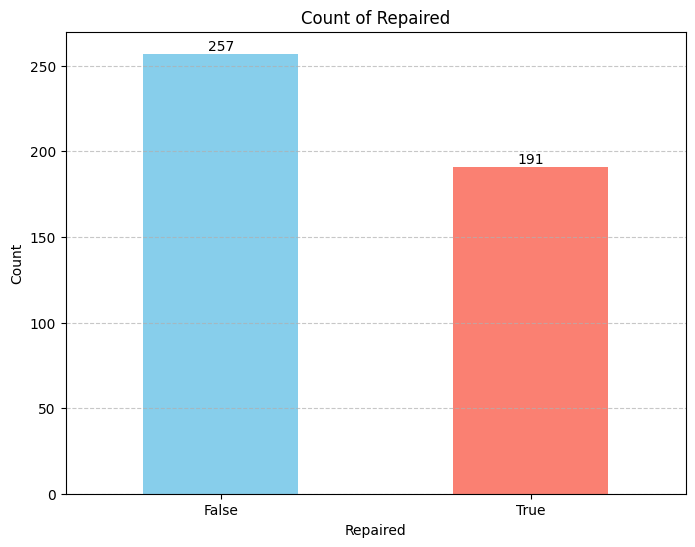

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Contar a quantidade de True e False na coluna 'Repaired'
contagem_repaired = mistral_table_df['Repaired'].value_counts()

# Criar o gráfico
plt.figure(figsize=(8, 6))
bars = contagem_repaired.plot(kind='bar', color=['skyblue', 'salmon'])

# Adicionar números sobre as barras
for bar in bars.patches:
    height = bar.get_height()
    bars.text(bar.get_x() + bar.get_width() / 2, height, int(height), ha='center', va='bottom')

plt.title('Count of Repaired')
plt.xlabel('Repaired')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['False', 'True'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

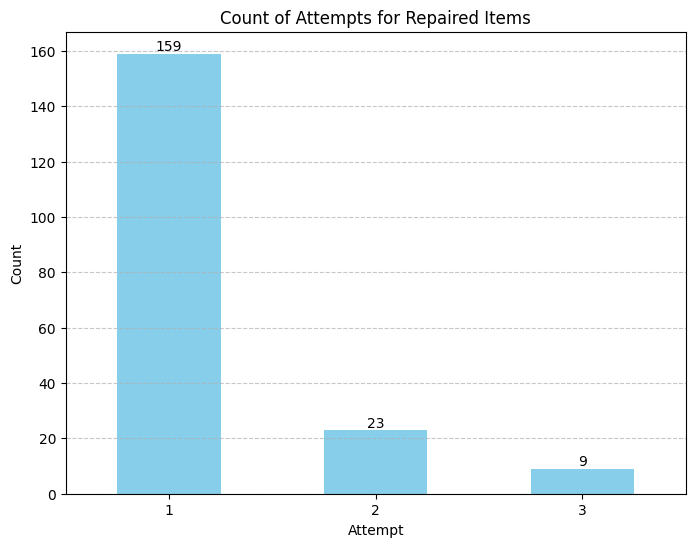

In [39]:
# Filtrar o DataFrame para incluir apenas as linhas onde 'Repaired' é True
filtered_df = mistral_table_df[mistral_table_df['Repaired'] == True]

# Contar a quantidade de cada valor em 'Attempt'
attempt_counts = filtered_df['Attempt'].value_counts()

# Mapear valores de Attempt para os rótulos desejados: 0 -> 1, 1 -> 2, 2 -> 3
attempt_counts.index = attempt_counts.index.map({0: 1, 1: 2, 2: 3})

# Criar o gráfico
plt.figure(figsize=(8, 6))
bars = attempt_counts.sort_index().plot(kind='bar', color='skyblue')

# Adicionar números sobre as barras
for bar in bars.patches:
    height = bar.get_height()
    bars.text(bar.get_x() + bar.get_width() / 2, height, int(height), ha='center', va='bottom')

plt.title('Count of Attempts for Repaired Items')
plt.xlabel('Attempt')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['1', '2', '3'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

C:\Users\filip\AppData\Local\Temp\ipykernel_1144\1522522375.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Match'] = filtered_df['Repair_Line'] == filtered_df['Line']


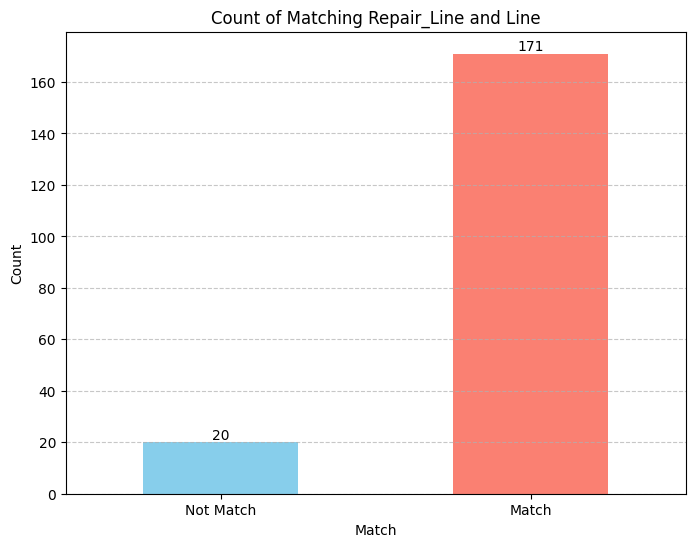

In [43]:
# Filtrar o DataFrame para incluir apenas as linhas onde 'Repaired' é True
filtered_df = mistral_table_df[mistral_table_df['Repaired'] == True]

# Verificar se 'Repair_Line' é igual a 'Line'
filtered_df['Match'] = filtered_df['Repair_Line'] == filtered_df['Line']

# Contar quantos são iguais e quantos não são iguais
match_counts = filtered_df['Match'].value_counts()

# Criar o gráfico
plt.figure(figsize=(8, 6))
bars = match_counts.sort_index().plot(kind='bar', color=['skyblue', 'salmon'])

# Adicionar números sobre as barras
for bar in bars.patches:
    height = bar.get_height()
    bars.text(bar.get_x() + bar.get_width() / 2, height, int(height), ha='center', va='bottom')

plt.title('Count of Matching Repair_Line and Line')
plt.xlabel('Match')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Not Match', 'Match'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

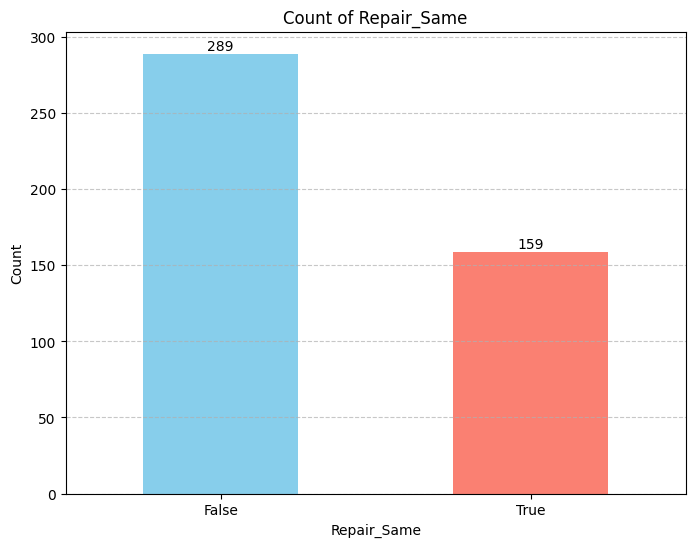

In [44]:
# Contar a quantidade de True e False na coluna 'Repair_Same'
repair_same_counts = mistral_table_df['Repair_Same'].value_counts()

# Criar o gráfico
plt.figure(figsize=(8, 6))
bars = repair_same_counts.sort_index().plot(kind='bar', color=['skyblue', 'salmon'])

# Adicionar números sobre as barras
for bar in bars.patches:
    height = bar.get_height()
    bars.text(bar.get_x() + bar.get_width() / 2, height, int(height), ha='center', va='bottom')

plt.title('Count of Repair_Same')
plt.xlabel('Repair_Same')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['False', 'True'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Claude2

In [49]:
claude_table = df.copy()
claude_table.columns

Index(['Name', 'Fault_Loc', 'Total_Lines', 'Type', 'Line', 'Verify',
       'Fault_Loc_Percentage', 'Category', 'Total_Lines_Num'],
      dtype='object')

In [50]:
claude_table = update_table_with_repair_info(claude_table, r"Repair\Claude2\Result")

In [51]:
claude_table = atualizar_tabela_com_reparo_original(claude_table)

In [52]:
claude_table = atualizar_tabela_com_reparo_comparacao(claude_table)

In [53]:
# Optionally, save the table to a CSV file
output_csv = r'Tables\repair_claude_table.csv'
claude_table.to_csv(output_csv, index=False)

In [54]:
claude_table.columns

Index(['Name', 'Fault_Loc', 'Total_Lines', 'Type', 'Line', 'Verify',
       'Fault_Loc_Percentage', 'Category', 'Total_Lines_Num', 'Repaired',
       'Attempt', 'Repair_Line', 'Repair_Fix', 'Repair_Original',
       'Repair_Same'],
      dtype='object')

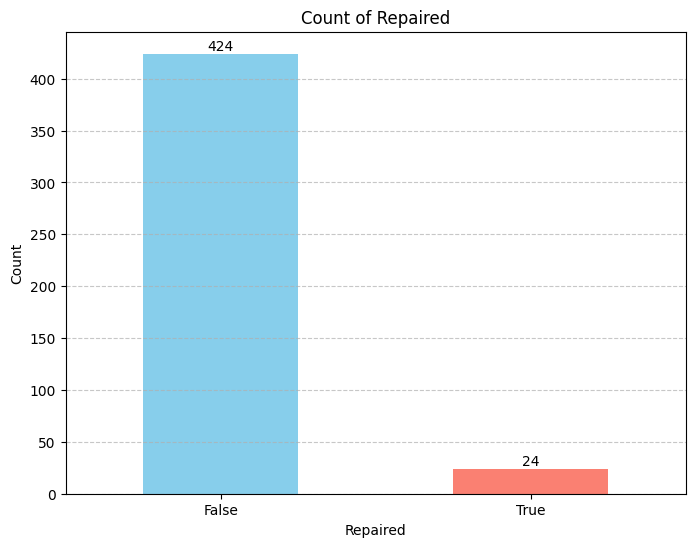

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Contar a quantidade de True e False na coluna 'Repaired'
contagem_repaired = claude_table['Repaired'].value_counts()

# Criar o gráfico
plt.figure(figsize=(8, 6))
bars = contagem_repaired.plot(kind='bar', color=['skyblue', 'salmon'])

# Adicionar números sobre as barras
for bar in bars.patches:
    height = bar.get_height()
    bars.text(bar.get_x() + bar.get_width() / 2, height, int(height), ha='center', va='bottom')

plt.title('Count of Repaired')
plt.xlabel('Repaired')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['False', 'True'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

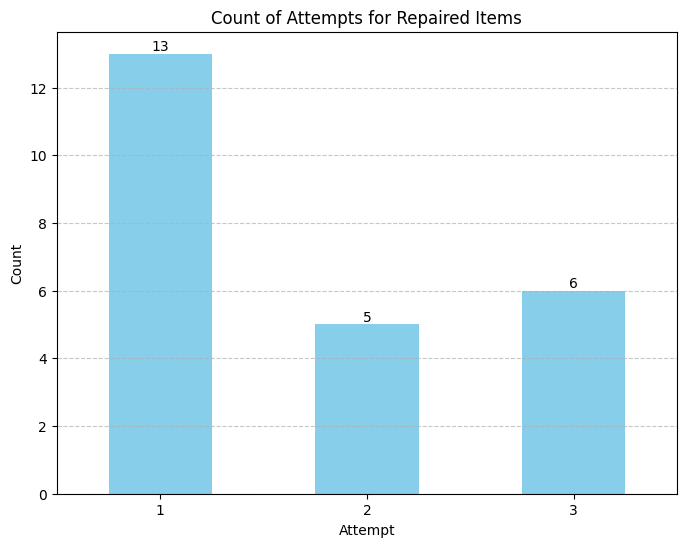

In [56]:
# Filtrar o DataFrame para incluir apenas as linhas onde 'Repaired' é True
filtered_df = claude_table[claude_table['Repaired'] == True]

# Contar a quantidade de cada valor em 'Attempt'
attempt_counts = filtered_df['Attempt'].value_counts()

# Mapear valores de Attempt para os rótulos desejados: 0 -> 1, 1 -> 2, 2 -> 3
attempt_counts.index = attempt_counts.index.map({0: 1, 1: 2, 2: 3})

# Criar o gráfico
plt.figure(figsize=(8, 6))
bars = attempt_counts.sort_index().plot(kind='bar', color='skyblue')

# Adicionar números sobre as barras
for bar in bars.patches:
    height = bar.get_height()
    bars.text(bar.get_x() + bar.get_width() / 2, height, int(height), ha='center', va='bottom')

plt.title('Count of Attempts for Repaired Items')
plt.xlabel('Attempt')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['1', '2', '3'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

C:\Users\filip\AppData\Local\Temp\ipykernel_1144\2094613527.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Match'] = filtered_df['Repair_Line'] == filtered_df['Line']


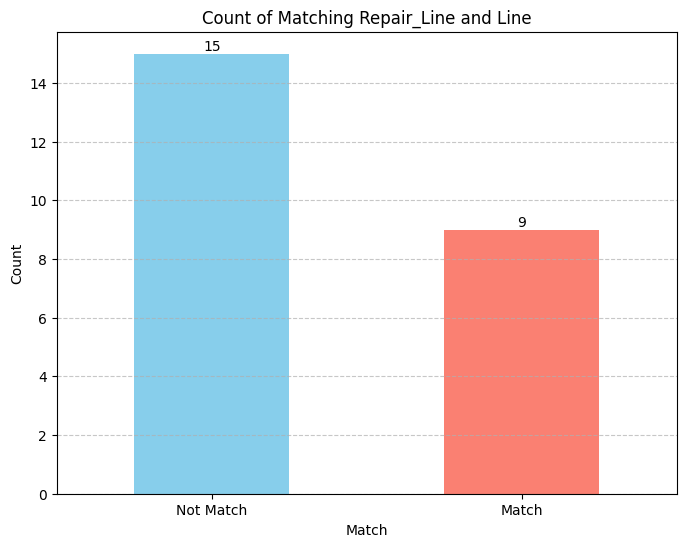

In [57]:
# Filtrar o DataFrame para incluir apenas as linhas onde 'Repaired' é True
filtered_df = claude_table[claude_table['Repaired'] == True]

# Verificar se 'Repair_Line' é igual a 'Line'
filtered_df['Match'] = filtered_df['Repair_Line'] == filtered_df['Line']

# Contar quantos são iguais e quantos não são iguais
match_counts = filtered_df['Match'].value_counts()

# Criar o gráfico
plt.figure(figsize=(8, 6))
bars = match_counts.sort_index().plot(kind='bar', color=['skyblue', 'salmon'])

# Adicionar números sobre as barras
for bar in bars.patches:
    height = bar.get_height()
    bars.text(bar.get_x() + bar.get_width() / 2, height, int(height), ha='center', va='bottom')

plt.title('Count of Matching Repair_Line and Line')
plt.xlabel('Match')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Not Match', 'Match'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

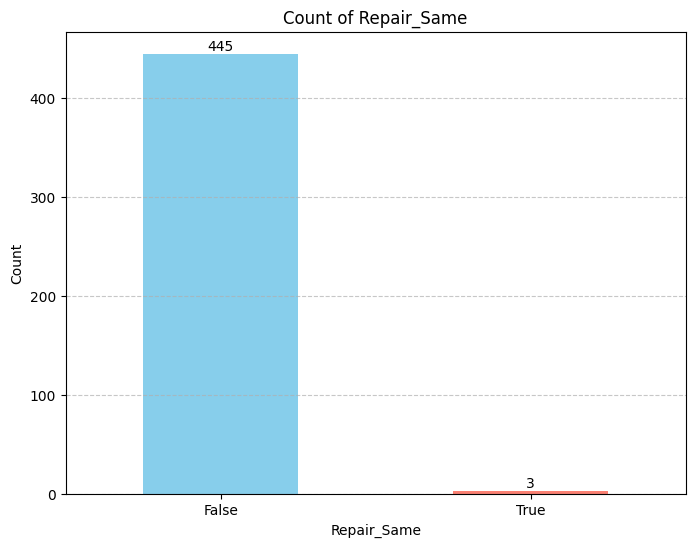

In [58]:
# Contar a quantidade de True e False na coluna 'Repair_Same'
repair_same_counts = claude_table['Repair_Same'].value_counts()

# Criar o gráfico
plt.figure(figsize=(8, 6))
bars = repair_same_counts.sort_index().plot(kind='bar', color=['skyblue', 'salmon'])

# Adicionar números sobre as barras
for bar in bars.patches:
    height = bar.get_height()
    bars.text(bar.get_x() + bar.get_width() / 2, height, int(height), ha='center', va='bottom')

plt.title('Count of Repair_Same')
plt.xlabel('Repair_Same')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['False', 'True'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()